In [2]:
# %pip install git+https://github.com/huggingface/transformers@21fac7abba2a37fae86106f87fcf9974fd1e3830 accelerate
%pip install torch torchvision torchaudio
# %pip install -U flash-attn --no-build-isolation
%pip install qwen-vl-utils
%pip install -q bitsandbytes

  Cloning https://github.com/huggingface/transformers (to revision 21fac7abba2a37fae86106f87fcf9974fd1e3830) to /tmp/pip-req-build-yzozfmue
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-yzozfmue
  Running command git rev-parse -q --verify 'sha^21fac7abba2a37fae86106f87fcf9974fd1e3830'
  Running command git fetch -q https://github.com/huggingface/transformers 21fac7abba2a37fae86106f87fcf9974fd1e3830
  Running command git checkout -q 21fac7abba2a37fae86106f87fcf9974fd1e3830
  Resolved https://github.com/huggingface/transformers to commit 21fac7abba2a37fae86106f87fcf9974fd1e3830
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl (797.1 

In [6]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import requests
import json
import base64

In [1]:
# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    # attn_implementation="flash_attention_2",
    device_map="cuda:0",
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
df.loc[len(df)-1]

image     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
artist                                                    4
genre                                                     1
style                                                    12
Name: 1131, dtype: object

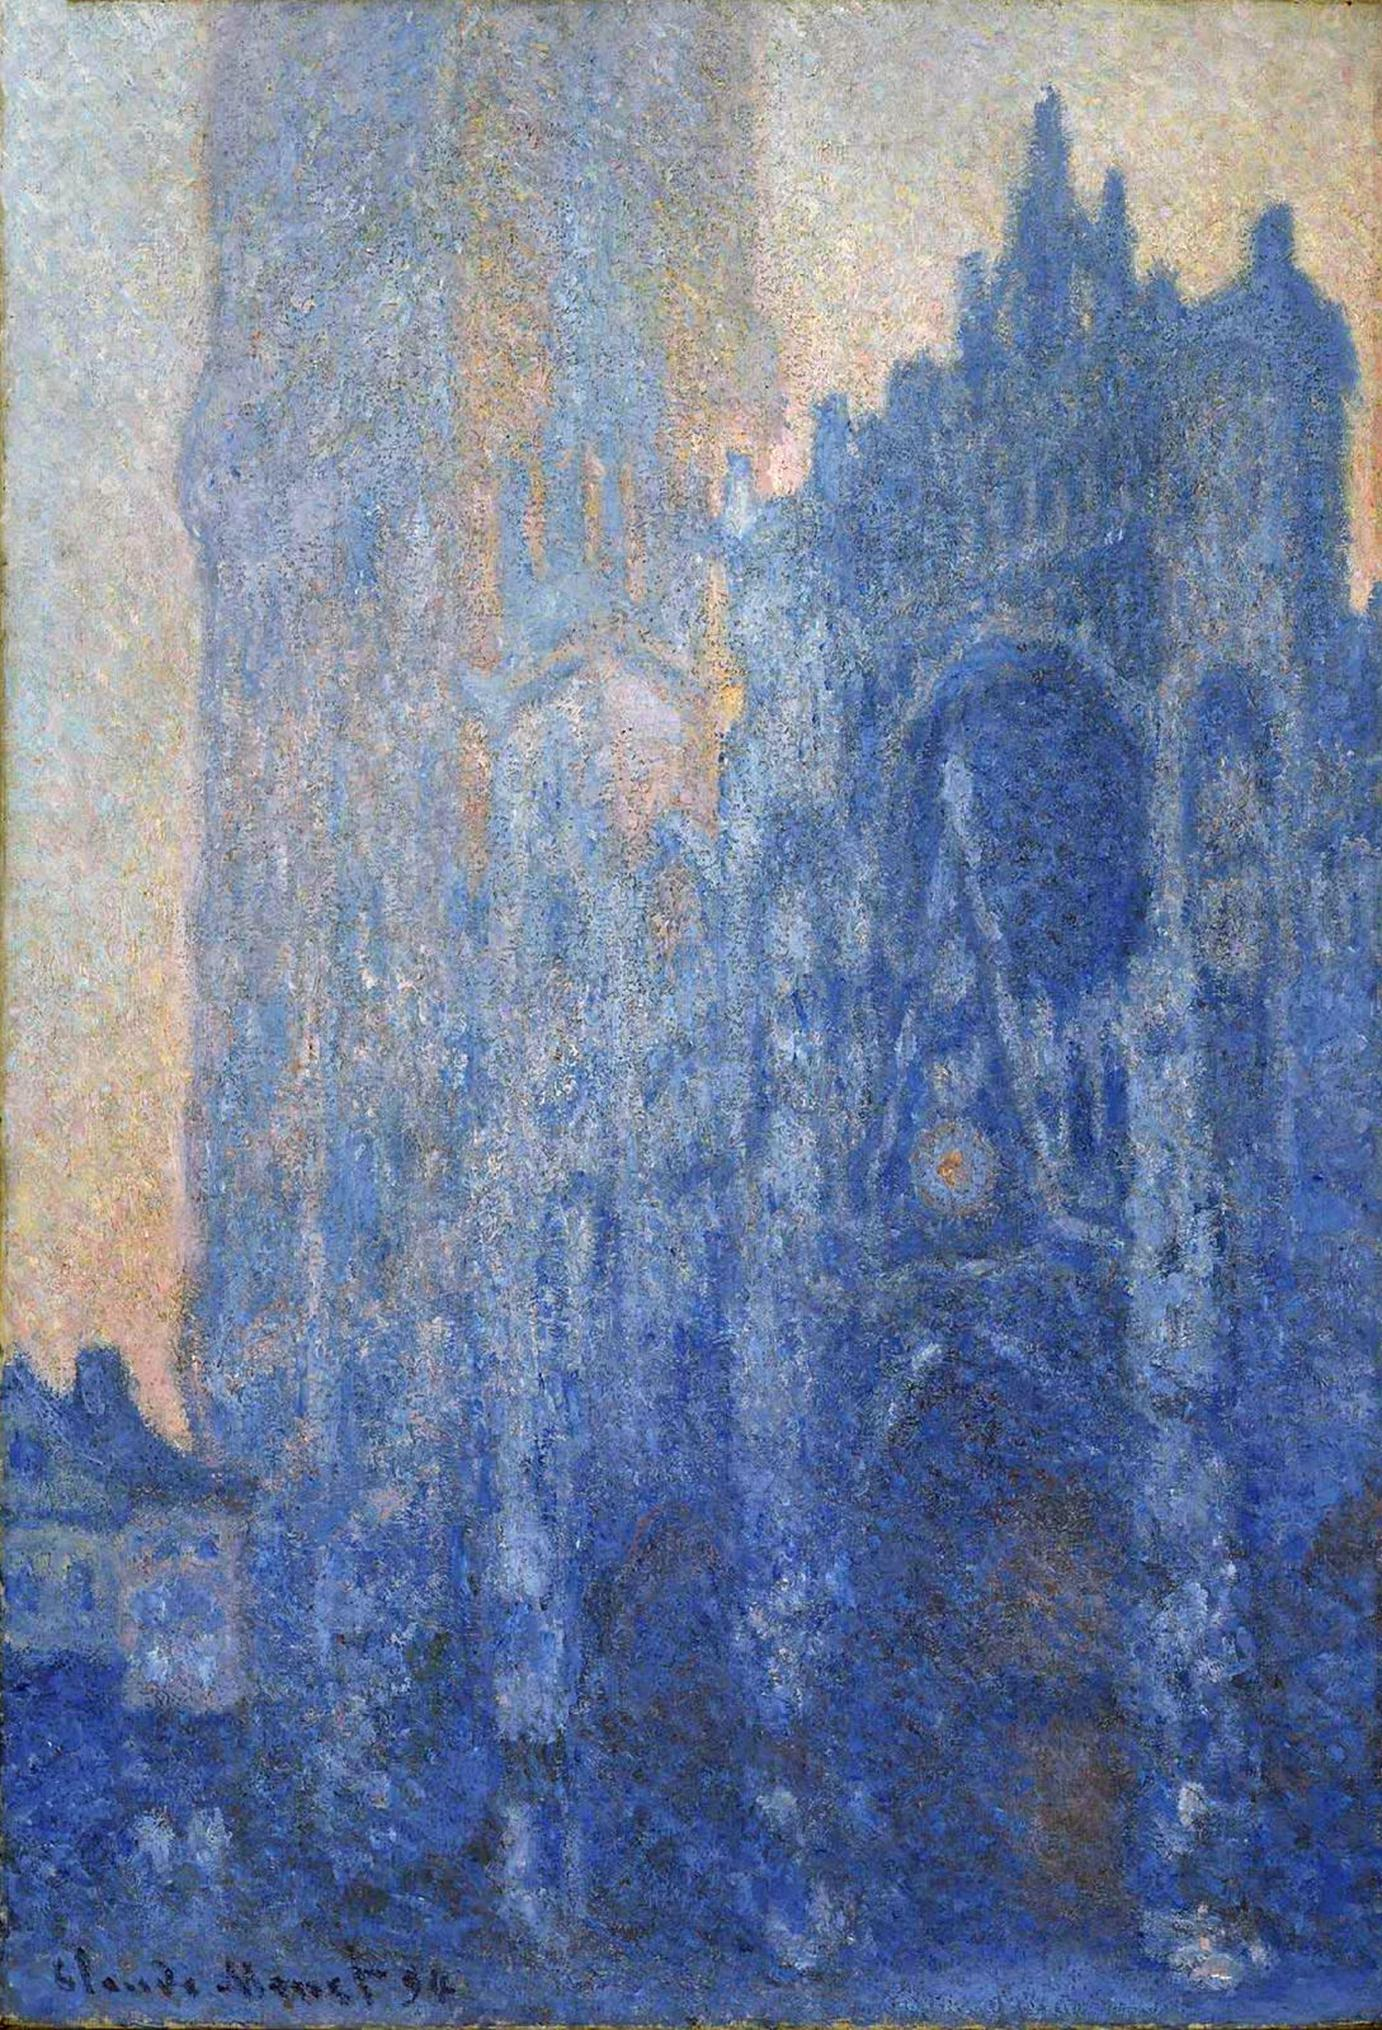

In [7]:
df = pd.read_parquet('./train-00000-of-00072.parquet')
image_bytes = df.loc[1131]['image']['bytes']
image_stream = BytesIO(image_bytes)
image = Image.open(image_stream)
image

In [2]:
import pandas as pd
import requests
import json

df = pd.read_parquet('./train-00000-of-00072.parquet')
# df.drop(df[df.genre == 10].index, inplace=True)
# df.reset_index(drop=True, inplace=True)

file_url = 'https://huggingface.co/datasets/huggan/wikiart/resolve/main/dataset_infos.json'
response = requests.get(file_url)

# Преобразуем содержимое в формат JSON
dataset_info = json.loads(response.content)

# Выводим содержимое JSON для анализа
# print(json.dumps(dataset_info, indent=4))
genres = dataset_info['huggan--wikiart']['features']['genre']['names']

artists =  dataset_info['huggan--wikiart']['features']['artist']['names']
artists_dict = {i: author for i, author in enumerate(artists)}

styles =  dataset_info['huggan--wikiart']['features']['style']['names']
styles_dict = {i: s for i, s in enumerate(styles)}

print(artists_dict)
print(styles_dict)
genres_str = '\n'.join([f'{i}: {g}' for i, g in enumerate(genres)])
genres_str

{0: 'Unknown Artist', 1: 'boris-kustodiev', 2: 'camille-pissarro', 3: 'childe-hassam', 4: 'claude-monet', 5: 'edgar-degas', 6: 'eugene-boudin', 7: 'gustave-dore', 8: 'ilya-repin', 9: 'ivan-aivazovsky', 10: 'ivan-shishkin', 11: 'john-singer-sargent', 12: 'marc-chagall', 13: 'martiros-saryan', 14: 'nicholas-roerich', 15: 'pablo-picasso', 16: 'paul-cezanne', 17: 'pierre-auguste-renoir', 18: 'pyotr-konchalovsky', 19: 'raphael-kirchner', 20: 'rembrandt', 21: 'salvador-dali', 22: 'vincent-van-gogh', 23: 'hieronymus-bosch', 24: 'leonardo-da-vinci', 25: 'albrecht-durer', 26: 'edouard-cortes', 27: 'sam-francis', 28: 'juan-gris', 29: 'lucas-cranach-the-elder', 30: 'paul-gauguin', 31: 'konstantin-makovsky', 32: 'egon-schiele', 33: 'thomas-eakins', 34: 'gustave-moreau', 35: 'francisco-goya', 36: 'edvard-munch', 37: 'henri-matisse', 38: 'fra-angelico', 39: 'maxime-maufra', 40: 'jan-matejko', 41: 'mstislav-dobuzhinsky', 42: 'alfred-sisley', 43: 'mary-cassatt', 44: 'gustave-loiseau', 45: 'fernando-bo

'0: abstract_painting\n1: cityscape\n2: genre_painting\n3: illustration\n4: landscape\n5: nude_painting\n6: portrait\n7: religious_painting\n8: sketch_and_study\n9: still_life\n10: Unknown Genre'

In [3]:
import base64
from io import BytesIO
from PIL import Image

# Convert the image bytes to base64
def image_to_base64(image):
    
    buffered = BytesIO()
    image.save(buffered, format="PNG")  # You can change the format to match the image type
    base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
    base64_image = f"data:image/png;base64,{base64_image}"
    return base64_image


In [25]:
prompt_t = """There are 11 possible genres:\n{genres_str}.\nWhat is the genre of painting by {artist}? Choose from list. Say only the number of genre, do not output anything else."""

In [4]:
prompt_t = """The task is to classify an image into one of the following 11 genres:\n{genres_str}.\nYou are provided with the name of the artist and the painting style of the image.\nArtist: {artist}\nStyle: {style} Based on this information, determine the correct genre. Choose the genre from the list by providing only the corresponding number. Say **ONLY** the number of the genre and **do not say anything else**."""

In [70]:
del inputs
del image_inputs
torch.cuda.empty_cache()

In [77]:
prompt_t = """You are an art expert.
The task is to classify an image into one of the following 11 genres:\n{genres_str}.
You are provided with the name of the artist: and the painting style of the image.\nArtist: {artist}\nStyle: {style}
\nUse all your knowledge, thought and given information to determine the most appropriate genre from the list. While thinking choose one genre and check if it describes the painting most accurately.
"Thoughts: (Provide chain of thought about genre here)"
"Answer: (Provide the genre number here)". """

In [12]:
from matplotlib import pyplot as plt
import time
import re

times=[]
predictions = []
correct_predictions = 0
total_predictions = len(df)
true_genres = df['genre'].tolist()

for idx, row in df.iterrows():
   
    if idx % 100 == 0:
        print('-'*50)
        print(idx)
        print('-'*50)

    image_bytes = row['image']['bytes']
    image_stream = BytesIO(image_bytes)
    image = Image.open(image_stream)
    img_file = BytesIO()
    image.save(img_file, 'png')
    img_file_size = img_file.tell() / 1024
    # print(img_file_size)
    image = image.resize((512, 512))
    del img_file
    img_file = BytesIO()
    image.save(img_file, 'png', optimize=True, quality=95)
    image = Image.open(img_file)
    del img_file

    artist = artists_dict[row['artist']]
    style = styles_dict[row['style']]
    prompt = prompt_t.format(genres_str=genres_str, artist=artist, style=style)
    
    image_base64_str = image_to_base64(image)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_base64_str},  # Base64 encoded image with MIME type
                {"type": "text", "text": prompt},
            ],
        }
    ]

    # Start generation
    with torch.no_grad():
        start_time = time.time()
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, _ = process_vision_info(messages)
        inputs = processor(
            text=[text],
            images=image_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda:0")

        generated_ids = model.generate(**inputs, max_new_tokens=512)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0]
        print(output_text)
        
        end_time = time.time() - start_time
        times.append(end_time)
        print(f'Time per message: {end_time:.2f} s')

        # regexp_res = re.search(r'Answer\D*(\d+)', output_text)
        # if regexp_res:
        #     answer = regexp_res.group(1)
        # else:
        #     answer = '12'
        pred = int(eval(output_text))
        # print(pred)

        # count_token = len(tokenizer(outputs_text, return_tensors="pt")['input_ids'][0].to("cpu"))
        # print(f'Token per message: {count_token}')
        # token.append(count_token)

        # token_per_second = count_token / end_time
        # print(f'Token per second: {token_per_second}')
        # tok_per_second.append(token_per_second)
        
        true_genre = row['genre']
        print(f'Genre:  {true_genre}')
        if pred == true_genre:
            correct_predictions += 1

        predictions.append(pred)
        del inputs
        del image_inputs
        # del video_inputs
        del generated_ids
        del generated_ids_trimmed
        torch.cuda.empty_cache()

--------------------------------------------------
0
--------------------------------------------------
4
Time per message: 0.18 s
Genre:  4
7
Time per message: 0.14 s
Genre:  7
6
Time per message: 0.17 s
Genre:  6
2
Time per message: 0.16 s
Genre:  2
2
Time per message: 0.17 s
Genre:  2
4
Time per message: 0.16 s
Genre:  4
7
Time per message: 0.17 s
Genre:  7
6
Time per message: 0.15 s
Genre:  6
4
Time per message: 0.14 s
Genre:  4
2
Time per message: 0.17 s
Genre:  2
4
Time per message: 0.16 s
Genre:  4
6
Time per message: 0.17 s
Genre:  6
6
Time per message: 0.16 s
Genre:  6
9
Time per message: 0.17 s
Genre:  9
8
Time per message: 0.16 s
Genre:  8
3
Time per message: 0.17 s
Genre:  3
4
Time per message: 0.16 s
Genre:  4
3
Time per message: 0.17 s
Genre:  3
8
Time per message: 0.13 s
Genre:  8
4
Time per message: 0.17 s
Genre:  4
4
Time per message: 0.15 s
Genre:  1
8
Time per message: 0.13 s
Genre:  8
6
Time per message: 0.15 s
Genre:  6
4
Time per message: 0.19 s
Genre:  1
4
Time p

In [11]:
correct_predictions

5

без 10 жанра

In [13]:
print(prompt_t)
print(output_text)
print(f'{correct_predictions / len(predictions):.3f}')

The task is to classify an image into one of the following 11 genres:
{genres_str}.
You are provided with the name of the artist and the painting style of the image.
Artist: {artist}
Style: {style} Based on this information, determine the correct genre. Choose the genre from the list by providing only the corresponding number. Say **ONLY** the number of the genre and **do not say anything else**.
4
0.694


In [79]:
print(prompt_t)
print(output_text)
print(f'{correct_predictions / len(predictions):.3f}')

You are an art expert.
The task is to classify an image into one of the following 11 genres:
{genres_str}.
You are provided with the name of the artist: and the painting style of the image.
Artist: {artist}
Style: {style}

Use all your knowledge, thought and given information to determine the most appropriate genre from the list. While thinking choose one genre and check if it describes the painting most accurately.
"Thoughts: (Provide chain of thought about genre here)"
'Answer: (Provide the genre number here)'. 
Thoughts: The painting features a cathedral, which is a common subject in cityscapes. The use of light and color, characteristic of Impressionism, suggests a focus on the effects of light on the scene. The overall composition and style align more closely with cityscapes than with other genres.

Answer: 1
0.599


In [73]:
print(prompt_t)
print(output_text)
print(f'{correct_predictions / len(predictions):.3f}')

You are an art expert.
The task is to classify an image into one of the following 11 genres:
{genres_str}.
You are provided with the name of the artist: and the painting style of the image.
Artist: {artist}
Style: {style}

Use all your knowledge, thought and given information to determine the most appropriate genre.
"Thoughts: (Provide chain of thought here)"
'Answer: (Provide the genre number here)'. 
Thoughts: The painting features a cathedral, which is a common subject in cityscapes. The style is Impressionism, which is known for its focus on capturing the effects of light and atmosphere. The use of light and color to create a sense of movement and mood is characteristic of Impressionist art.

Answer: 1
0.598


In [47]:
print(prompt_t)
print(f'{correct_predictions / len(predictions):.2f}')

The task is to classify an image into one of the following 11 genres:
{genres_str}.
You are provided with the name of the artist: and the painting style of the image.
Artist: {artist}
Style: {style}
Use all your knowledge and given information to determine the correct genre. Choose the genre from the list by providing only the corresponding number. Say **ONLY** the number of the genre and **do not say anything else**. THIS IS VEY IMPORTANT FOR MY CAREER I WILL TIP YOU 1000000000$ for the correct answer.
0.60


In [40]:

print(prompt_t)
correct_predictions / len(predictions)

There are 11 possible genres:
{genres_str}.
What is the genre of painting by {artist}? Choose from list. Say only the number of genre, do not output anything else.


0.6024734982332155